# 1 Facial Emotion Recognition with Scikit-learn

In this tutorial, we will introduce scikit-learn for an important problem in Affective Computing, namely Facial Emotion Recognition (FER).

At the end of this tutorial:

* You will have a more practical feeling of the FER problem.
* You will have some familiarity with the scikit-learn library.
* You will have seen how a supervised model (namely Support Vector Machines) can be used for the FER problem.

By making very minor changes in this tutorial,
* You can study FER for other datasets.
* You can study other problems in affective computing using scikit-learn.
* You can try out many different machine learning models in scikit-learn.

**Acknowledgment**

Some snippets are adapted from: https://scikit-learn.org/stable/tutorial/basic/tutorial.html#introduction

## 1.1 A FER Dataset: Japanese Female Facial Expressions (JAFFE)

The dataset contains 7 facial expressions of 10 Japanese female models. In total, it contains 213 images with resolution $256\times 256$. Each image has been annotate by 60 Japanese participants.

**Paper**: Michael J. Lyons, Shigeru Akamatsu, Miyuki Kamachi, Jiro Gyoba. "Coding Facial Expressions with Gabor Wavelets", 3rd IEEE International Conference on Automatic Face and Gesture Recognition, pp. 200-205 (1998).

**Dataset page**: https://zenodo.org/record/3451524

**Samples**

<img align="center" width="50%" src="https://ars.els-cdn.com/content/image/1-s2.0-S1319157818303379-gr2_lrg.jpg">

## 1.2 Scikit-Learn

[Scikit-learn](scikit-learn.org) is a general purpose, comprehensive, easy to use machine learning library in Python. It provides implementations of many different varieties of learning methods and the accompanying tools for training and analyzing them.

For the list of supervised and unsupervised learning models, you can check out the following pages from the scikit documentation:
* [Scikit-learn supervised learning methods](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
* [Scikit-learn unsupervised learning methods](https://scikit-learn.org/stable/unsupervised_learning.html#unsupervised-learning)

What makes scikit-learn unique is that it provides a standard API for all learning models. This allows one to test any learning method provided by scikit-learn without resorting to any changes in your code.

# 2 Getting and Preparing the JAFFE Dataset

In [ ]:
# Import libraries
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40
import random

In [ ]:
# + Download the dataset from the Internet
# .  (-c avoids redownloading if the file is already available)
#
# UPDATE: The dataset owners disabled direct access to the dataset. Now, you need
#         to register to be able to download it: https://zenodo.org/record/3451524
#
!wget -c "https://zenodo.org/record/3451524/files/jaffedbase.zip"

# + unzip the directory (-q means quiet mode; -o means overwrite files)
print("Unzipping the zip file 'jaffedbase.zip'")
!unzip -qo jaffedbase.zip

--2021-03-22 09:36:47--  https://zenodo.org/record/3451524/files/jaffedbase.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 429 Too Many Requests
2021-03-22 09:36:47 ERROR 429: Too Many Requests.

Unzipping the zip file 'jaffedbase.zip'


In [ ]:
# Load the dataset from the disk

def get_label_from_filename(filename):
  """ Given a filename of the format 'NM.NE2.93.tiff', return the label 'NE'."""
  index = filename.find('.')
  return filename[index+1:index+3]

rows=64
cols=64
channels=3
num_classes=7

emotion_to_int =  {"AN":0, "DI":1, "FE":2, "NE":3, "SA":4, "SU":5, "HA":6}
int_to_emotion =  {0:"AN", 1:"DI", 2:"FE", 3:"NE", 4:"SA", 5:"SU", 6:"HA"}
emotion_list = emotion_to_int.keys()

img_data_list = []
labels_list = []

print("Reading the img files...")
data_path = './jaffedbase/'
for img in os.listdir(data_path):
  if "tiff" not in img: continue # Process only img files
  # Read the image
  input_img = cv2.imread(data_path + "/" + img)
  input_img_resize = cv2.resize(input_img,(rows,cols))
  img_data_list.append(input_img_resize)

  # Read the label
  emotion = get_label_from_filename(img)
  emotion_int = emotion_to_int[emotion] # convert to index
  labels_list.append(emotion_int)

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255 # Normalize between [0-1]
img_data = img_data.reshape((len(img_data), -1)) # Flatten the images
labels = np.array(labels_list)

num_images = img_data.shape[0]

# Split the data into train and test set
train_size = int(num_images*0.8) # reserve 80% for training, 20% for testing
train_images = img_data[0:train_size]
train_labels = labels[0:train_size]
test_images = img_data[train_size:]
test_labels = labels[train_size:]


print("... finished with the input and labels as follows: ")
print("-- train_images.shape: ", train_images.shape)
print("-- train_labels.shape: ", train_labels.shape)
print("-- test_images.shape: ", test_images.shape)
print("-- test_labels.shape: ", test_labels.shape)
print("-- The number of images: ", num_images)

Reading the img files...
... finished with the input and labels as follows: 
-- train_images.shape:  (170, 12288)
-- train_labels.shape:  (170,)
-- test_images.shape:  (43, 12288)
-- test_labels.shape:  (43,)
-- The number of images:  213


## 2.1 Display some samples

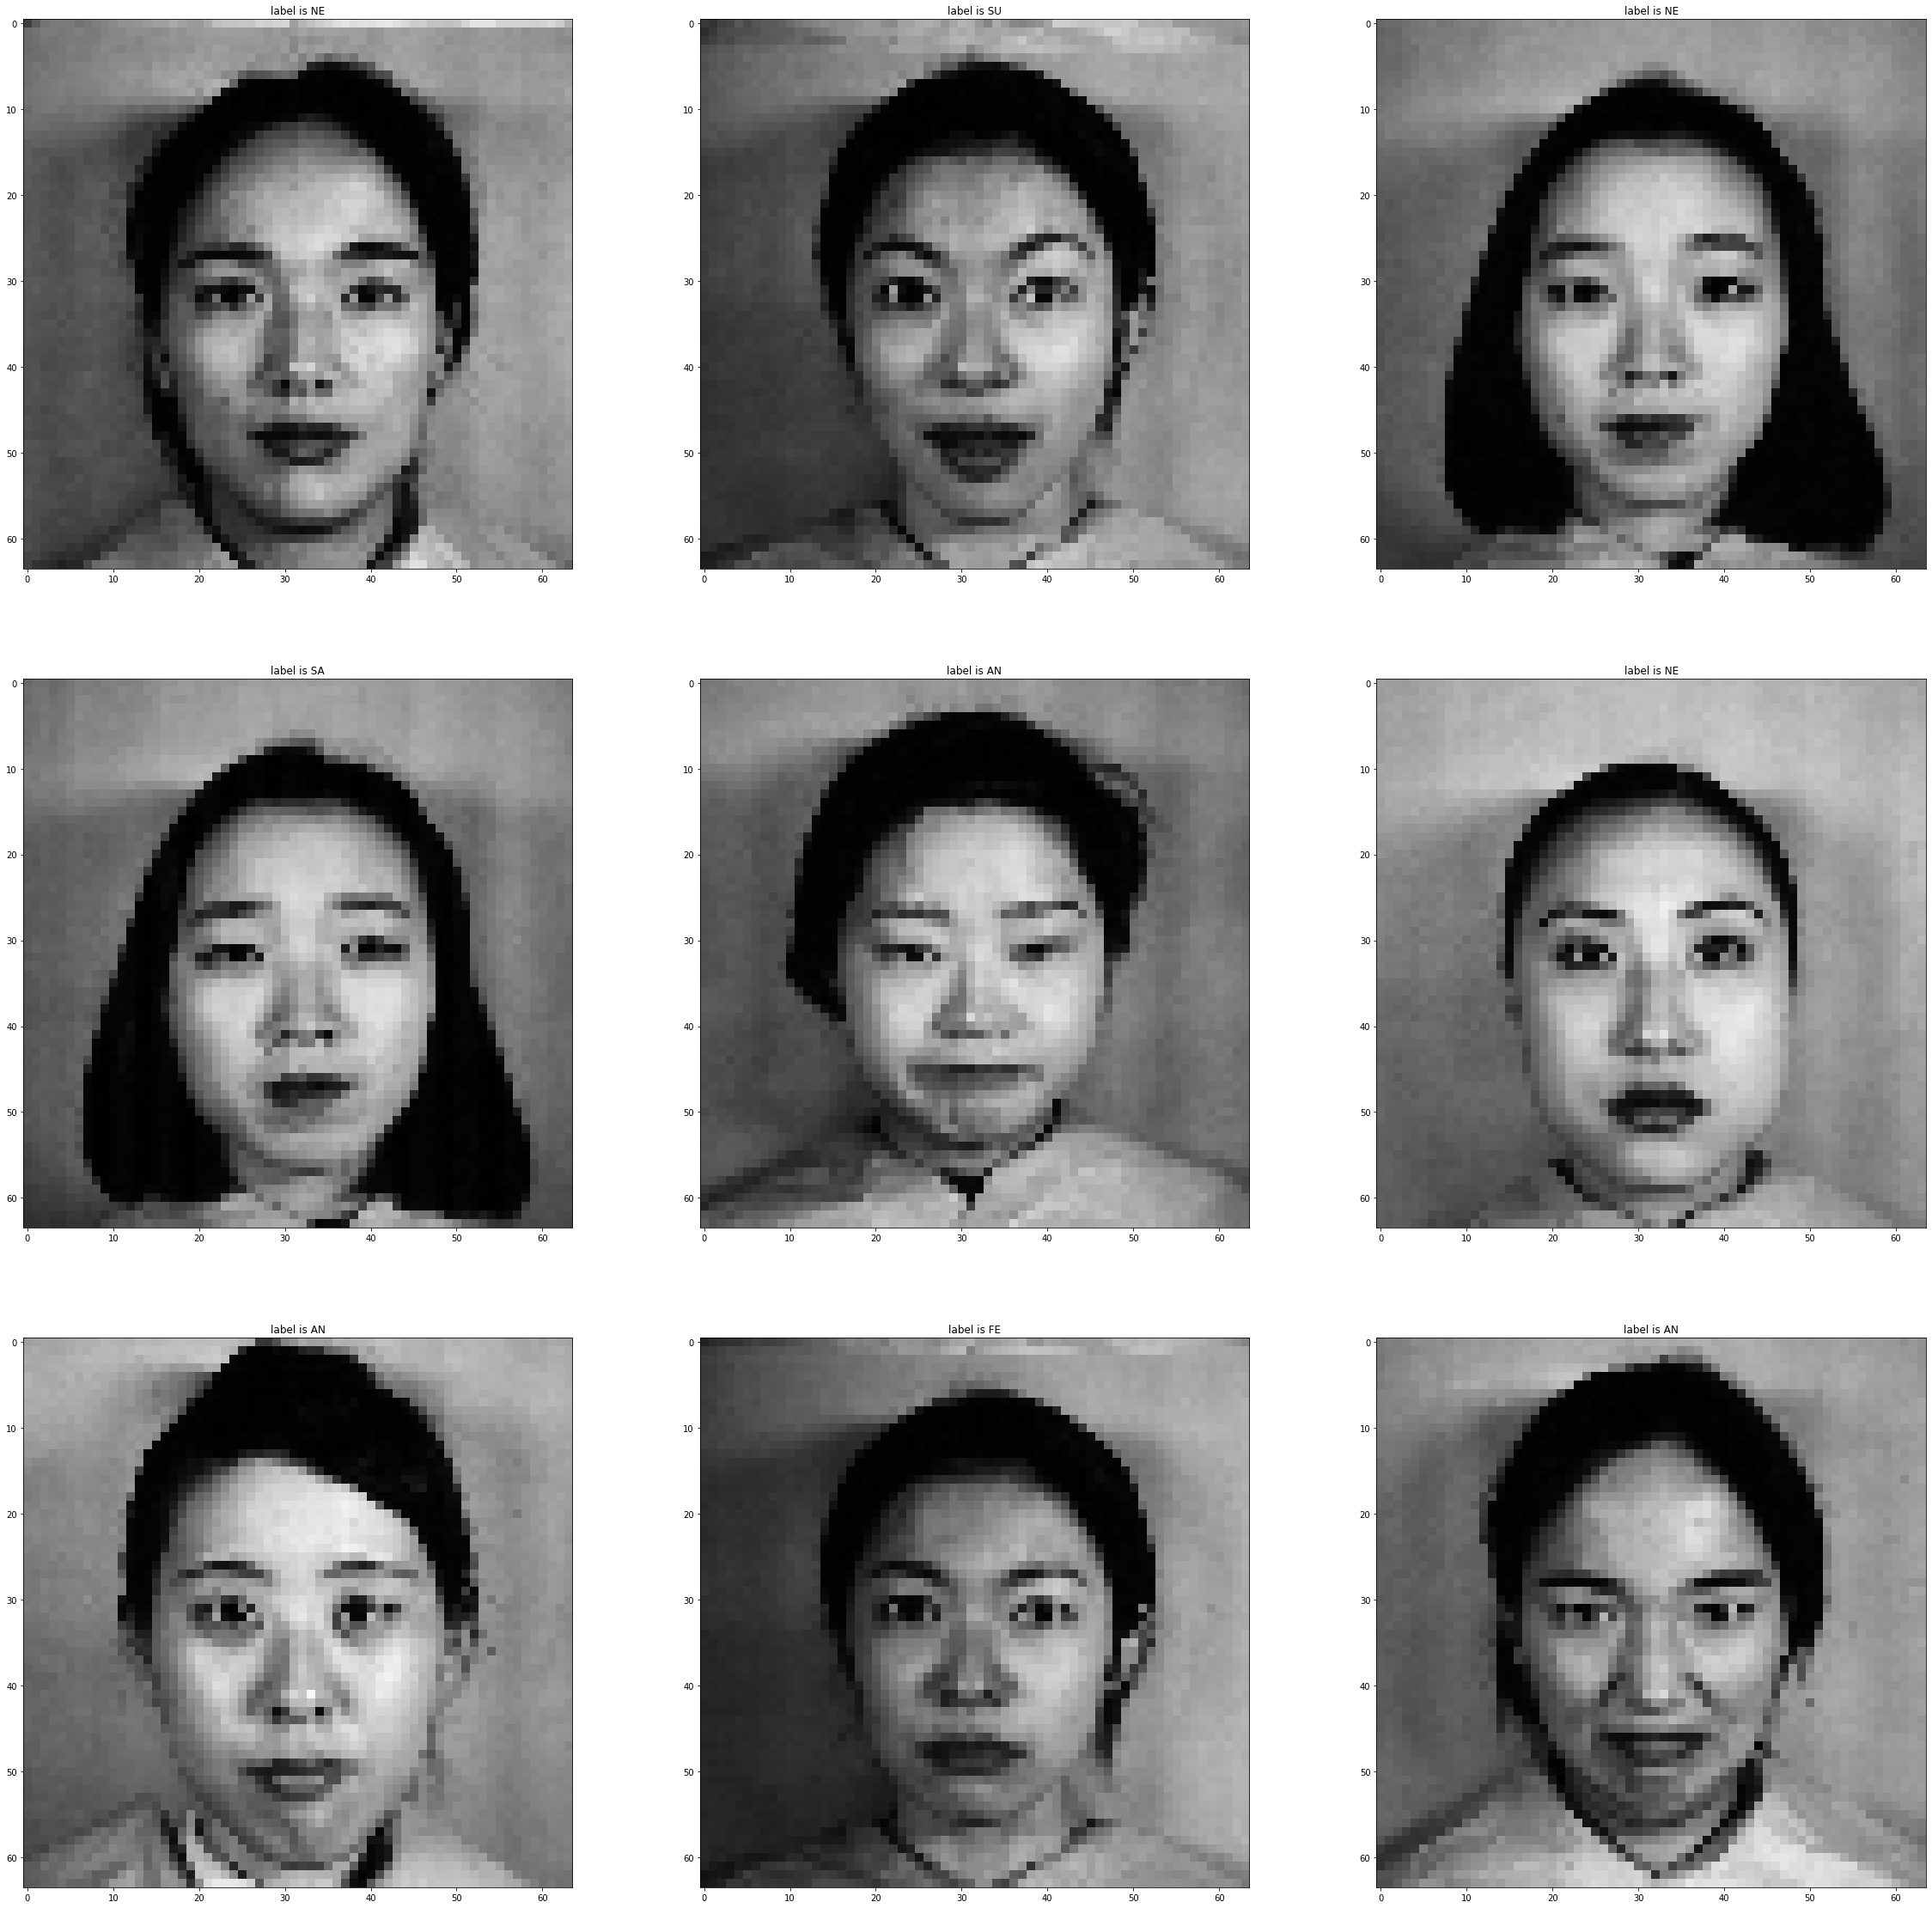

In [ ]:
# Create an NxN display of samples
N = 3
fig, axs = plt.subplots(N, N)

for i in range(3):
  for j in range(3):
    index = random.randint(0, 213-1) # pick a random index
    img = img_data[index]
    img = img.reshape(cols, rows, channels)
    label = labels[index]
    axs[i, j].imshow(img)
    axs[i, j].set_title("label is " + int_to_emotion[label])

# 3 FER with Support Vector Machines (SVM)

SVM is one of the oldest methods in machine learning. It aims to find the boundary that *best* separates the two classes in the feature space:
<img width="70%" src="https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png">
*[Image source: [Scikit-learn](https://scikit-learn.org/stable/modules/svm.html)]*

The optimization problem solved by SVM can be formulated as follows (following the formulation in [scikit-learn documentation](https://scikit-learn.org/stable/modules/svm.html)):
$$
\min_{w,b,\zeta} \frac{1}{2}w^T w + C\sum_i \zeta_i
$$
subject to:
$$
y_i (w^T\phi(x_i)+b) \ge 1-\zeta_i, \zeta_i \ge 0, i=1, ..., n.
$$
where $x_i\in\mathbb{R}^p$ is an input vector with correct label $y_i\in\{1,-1\}$; $w,b$ is the set of parameters defining the boundary; $C$ is the regularization parameter, controlling the complexity of the learned solution; $\phi(\cdot)$ is a function that maps $x$ vectors into a higher-dimensional space (in kernel form: $\kappa(x_i, x_j) = \phi(x_i)\phi(x_j)$) can be used for finding various types of boundaries; and $\zeta_i$ are the slack variables.

We will try an SVM with the Radial Basis Function kernel:
$$
\kappa(x, x') = \gamma \exp\left(||x-x'||^2\right),
$$
where $\gamma$ is a positive constant (a hyper-parameter). Alternative kernels include:
* Linear kernel: $\kappa(x,x')=<x,x'>$.
* Polynomial kernel: $\kappa(x,x')=(\gamma<x,x'>+r)^d$.
* Sigmoid/tanh: $\kappa(x,x')=\tanh(\gamma<x,x'>+r)$.
* or any kernel that you can define in Python.

For more information, see and the following illustration from scikit-learn:
https://scikit-learn.org/stable/modules/svm.html

<img width="70%" src="https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png">

## 3.1 Define an SVM model

Let us define an SVM model with RBF kernel, $\gamma=0.001$ and $C=1.0$ (default value).

In [ ]:
from sklearn import svm, metrics

# Create a classifier: a support vector classifier
# This is with RBF kernel
classifier = svm.SVC(gamma=0.001)

print("classifier: ", classifier)
# C: From the doc: "For larger values of C, a smaller margin will be accepted if the decision
# .  function is better at classifying all training points correctly. A lower C will encourage
#    a larger margin, therefore a simpler decision function, at the cost of training accuracy.
#     In other words ``C`` behaves as a regularization parameter in the SVM."
# OVR: One-versus-rest (alternative: ovo -- One-versus-one)
# Kernel (RBF): Radial Basis Functions
# Probability (False): Estimate the probability for class membership from scores
# class_weight (None): Give more weight to some classess
# coef0: Constant r in the kernel definition (see above)
#

classifier:  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


## 3.2 Train SVM


In [ ]:
# We learn the SVM model on the training data
classifier.fit(train_images, train_labels)

# Now predict on the test data
predicted = classifier.predict(test_images)
expected = test_labels

## 3.3 Results

### 3.3.1 Quantitative Results

In [ ]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.20      1.00      0.33         1
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         8
           4       0.07      1.00      0.13         2
           5       0.38      0.43      0.40         7
           6       0.00      0.00      0.00         7

    accuracy                           0.16        43
   macro avg       0.23      0.37      0.16        43
weighted avg       0.21      0.16      0.12        43




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.3.2 Confusion Matrix

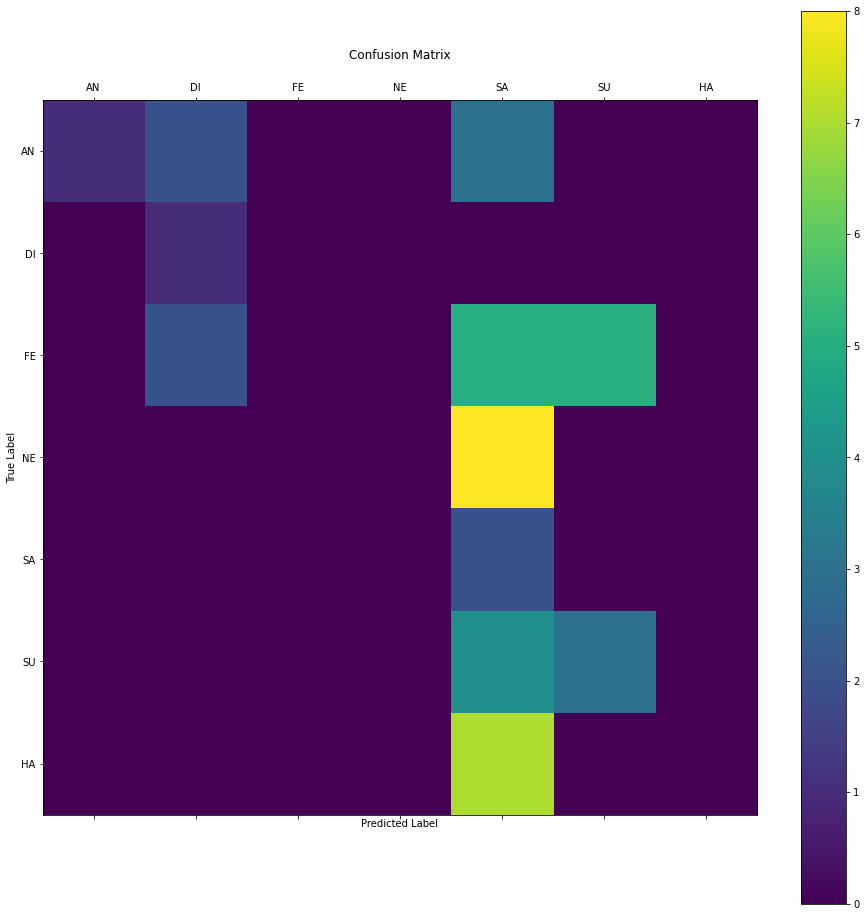

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predicted)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(ticks=range(0,7), labels=list(emotion_to_int.keys()))
plt.yticks(ticks=range(0,7), labels=list(emotion_to_int.keys()))
plt.show()

### 3.3.3 Qualitative Results

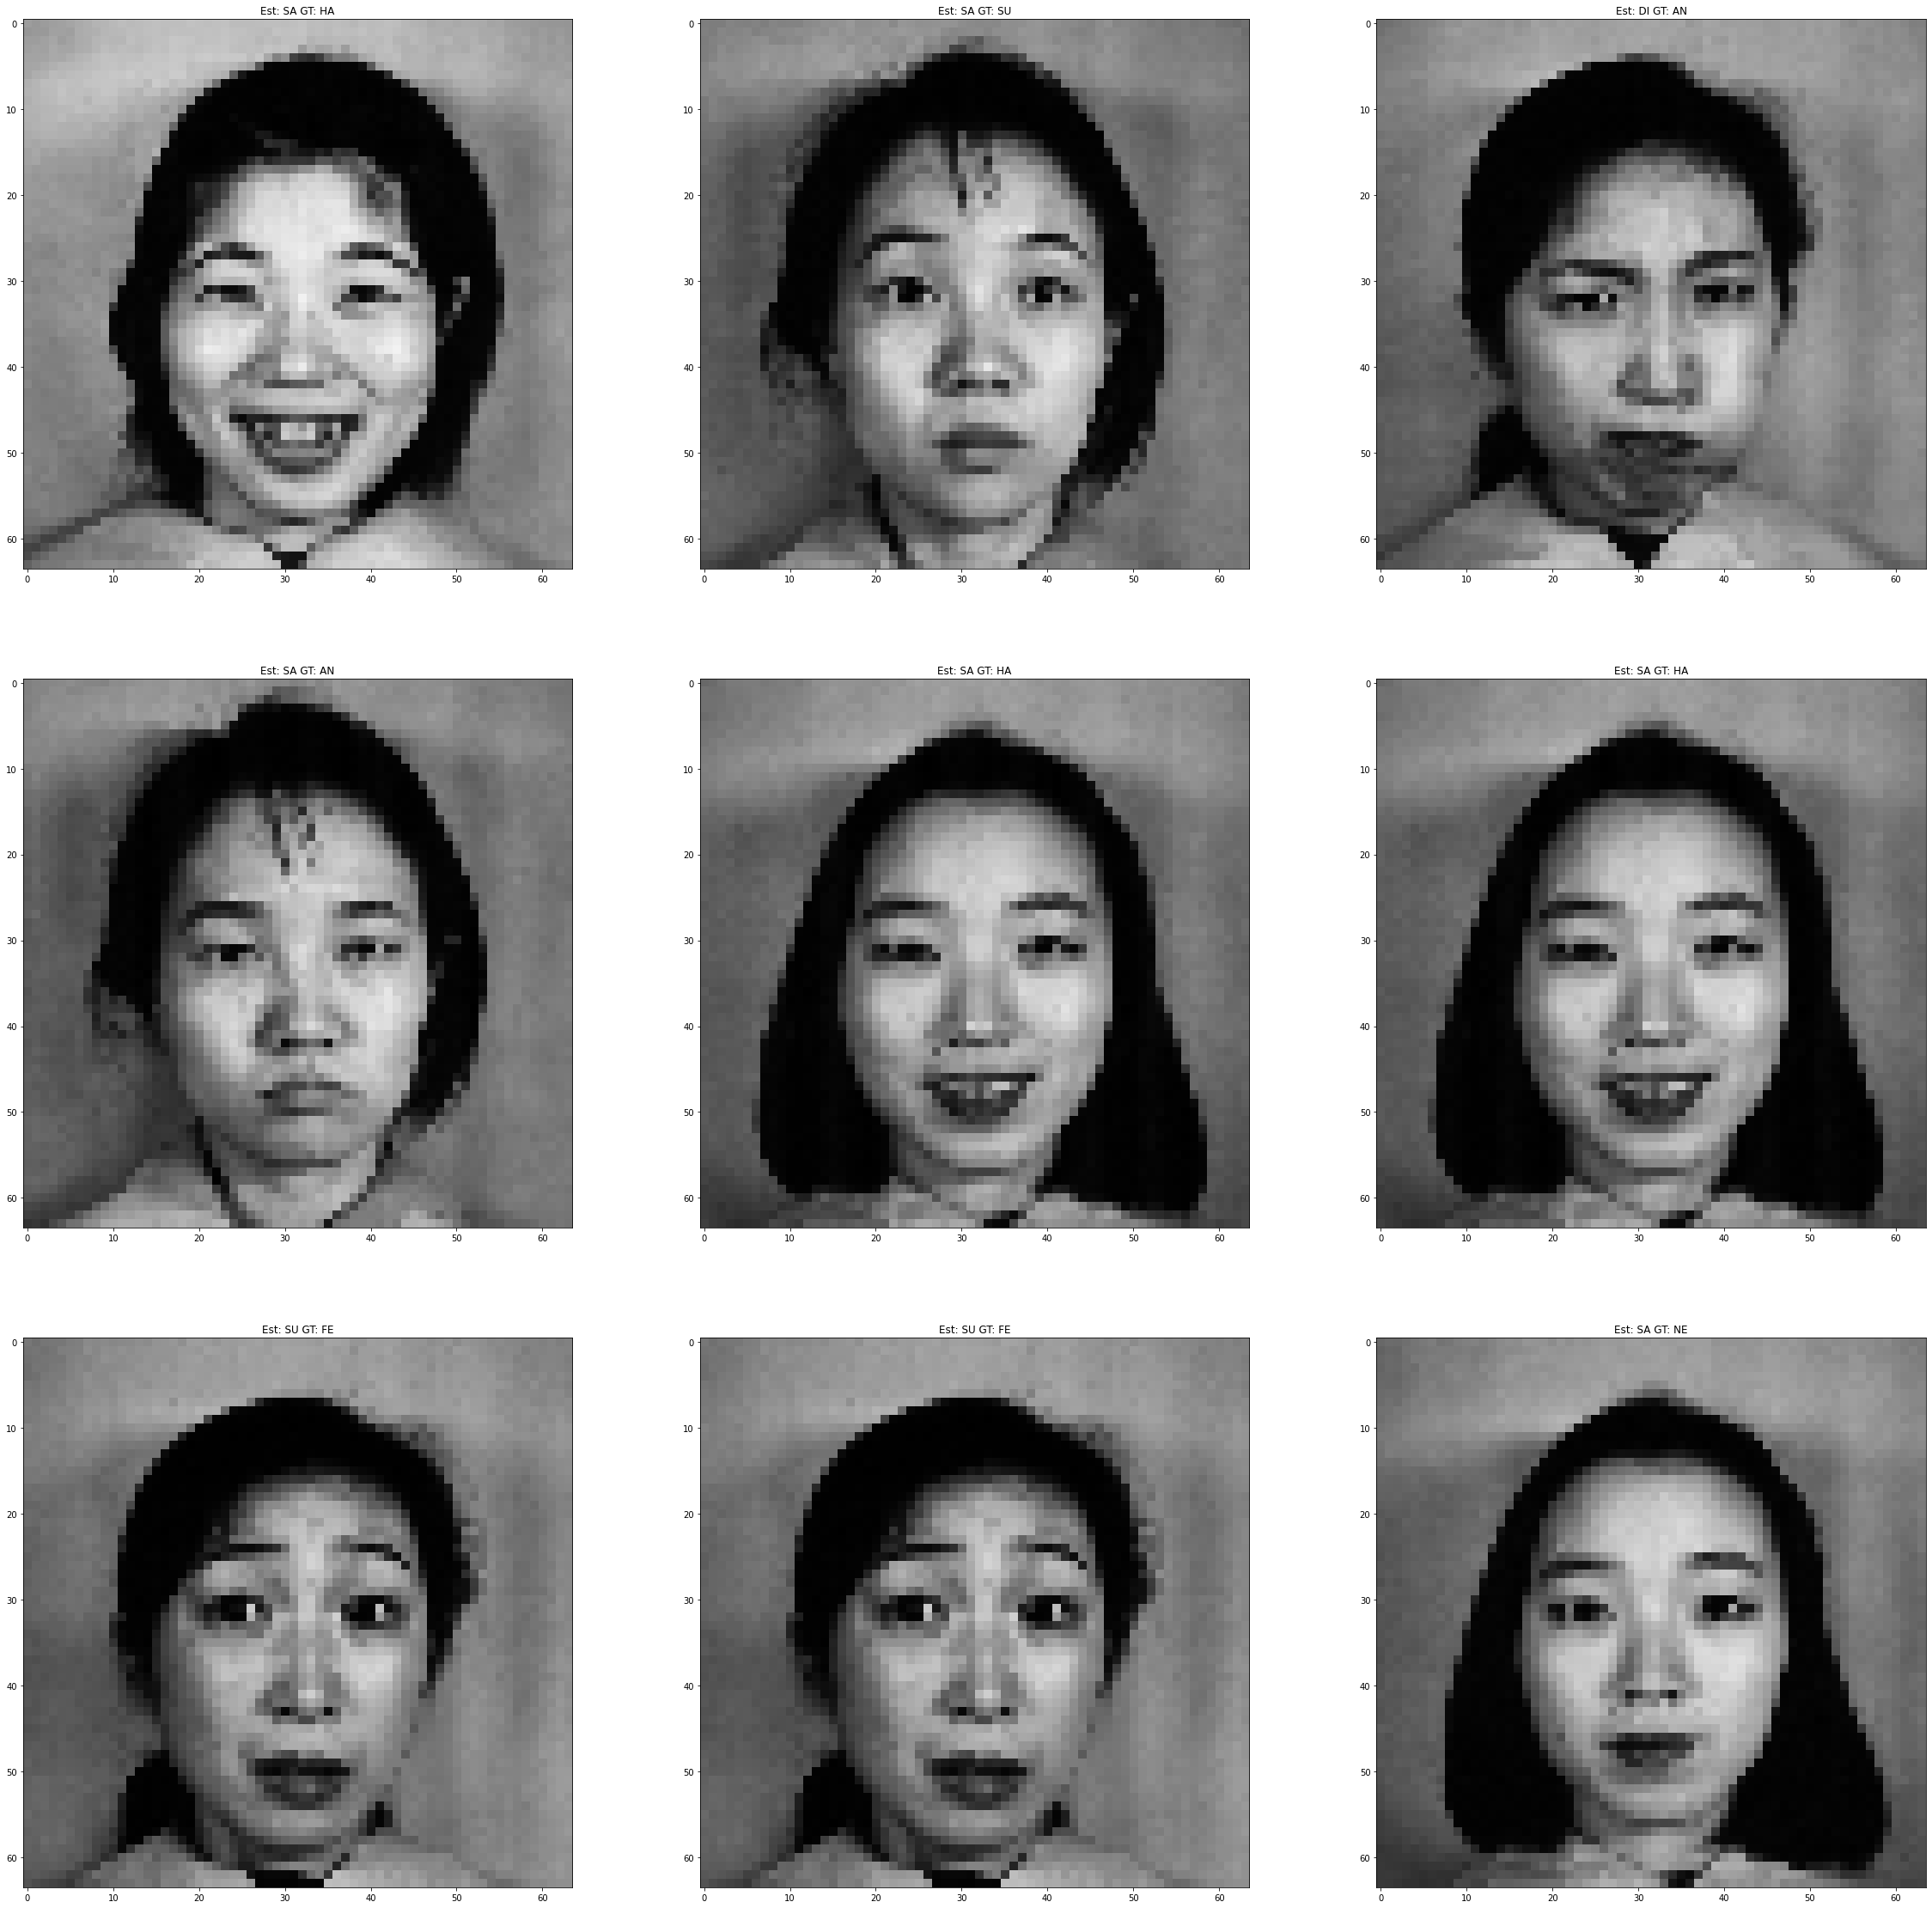

In [ ]:
# Create an NxN display of samples
N = 3
fig, axs = plt.subplots(N, N)

for i in range(3):
  for j in range(3):
    index = random.randint(0, len(test_images)-1) # pick a random index
    img = test_images[index].reshape(cols, rows, channels)
    correct_label = test_labels[index]
    predicted_label = predicted[index]

    axs[i, j].imshow(img)
    axs[i, j].set_title("Est: " + int_to_emotion[predicted_label] + " GT: " + int_to_emotion[correct_label])

## 3.4 Grid Search for Hyper-Parameters

The results were far from being useful.

Adapted from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Specify the ranges to be searched for hyper-parameters
C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(gamma=gamma_range, C=C_range)

# Do cross validation
cv = KFold() # default n_splits = 5
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(train_images, train_labels)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

#This printed the following for me:
# The best parameters are {'C': 10000.0, 'gamma': 0.001} with a score of 0.81

The best parameters are {'C': 10000000.0, 'gamma': 1e-06} with a score of 0.83


### 3.4.1 Train the model with the best parameters

In [ ]:
best_SVM = svm.SVC(C=10000000.0, gamma=1e-06)
best_SVM.fit(train_images, train_labels)

SVC(C=10000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1e-06,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### 3.4.2 Evaluate the best model

In [ ]:
predicted = best_SVM.predict(test_images)
expected = test_labels

print("Classification report for classifier %s:\n%s\n"
      % (best_SVM, metrics.classification_report(expected, predicted)))

Classification report for classifier SVC(C=10000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1e-06,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.50      1.00      0.67         1
           2       1.00      0.75      0.86        12
           3       0.67      1.00      0.80         8
           4       0.67      1.00      0.80         2
           5       0.86      0.86      0.86         7
           6       1.00      0.57      0.73         7

    accuracy                           0.84        43
   macro avg       0.81      0.88      0.82        43
weighted avg       0.89      0.84      0.84        43




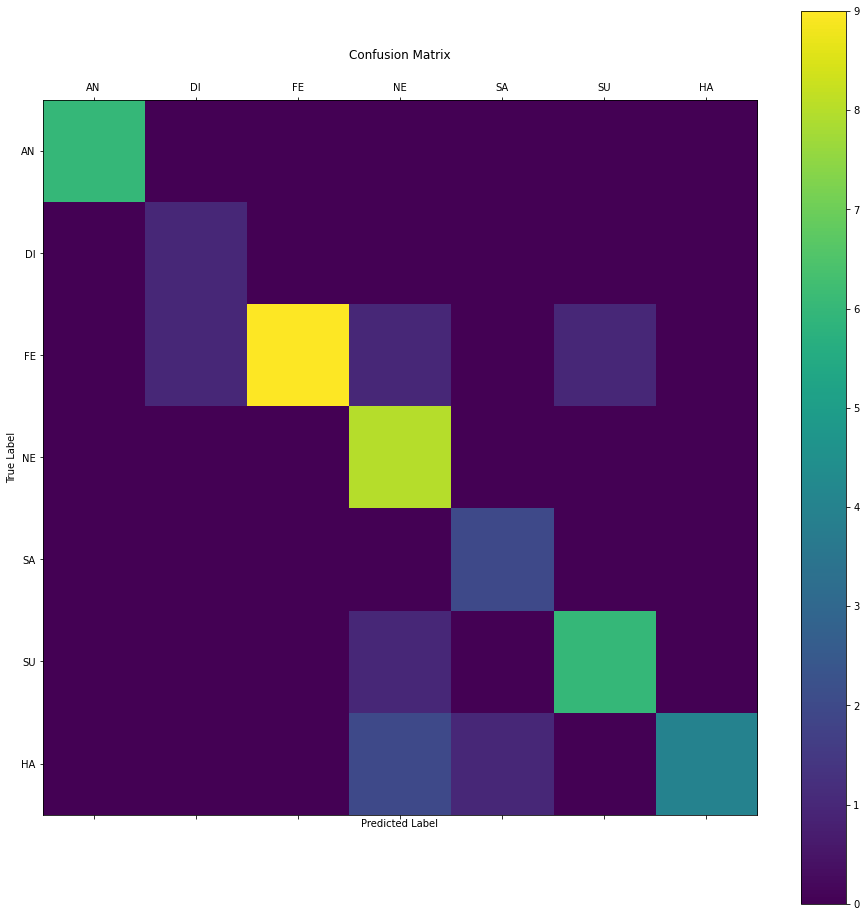

In [ ]:
cm = confusion_matrix(test_labels, predicted)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(ticks=range(0,7), labels=list(emotion_to_int.keys()))
plt.yticks(ticks=range(0,7), labels=list(emotion_to_int.keys()))
plt.show()

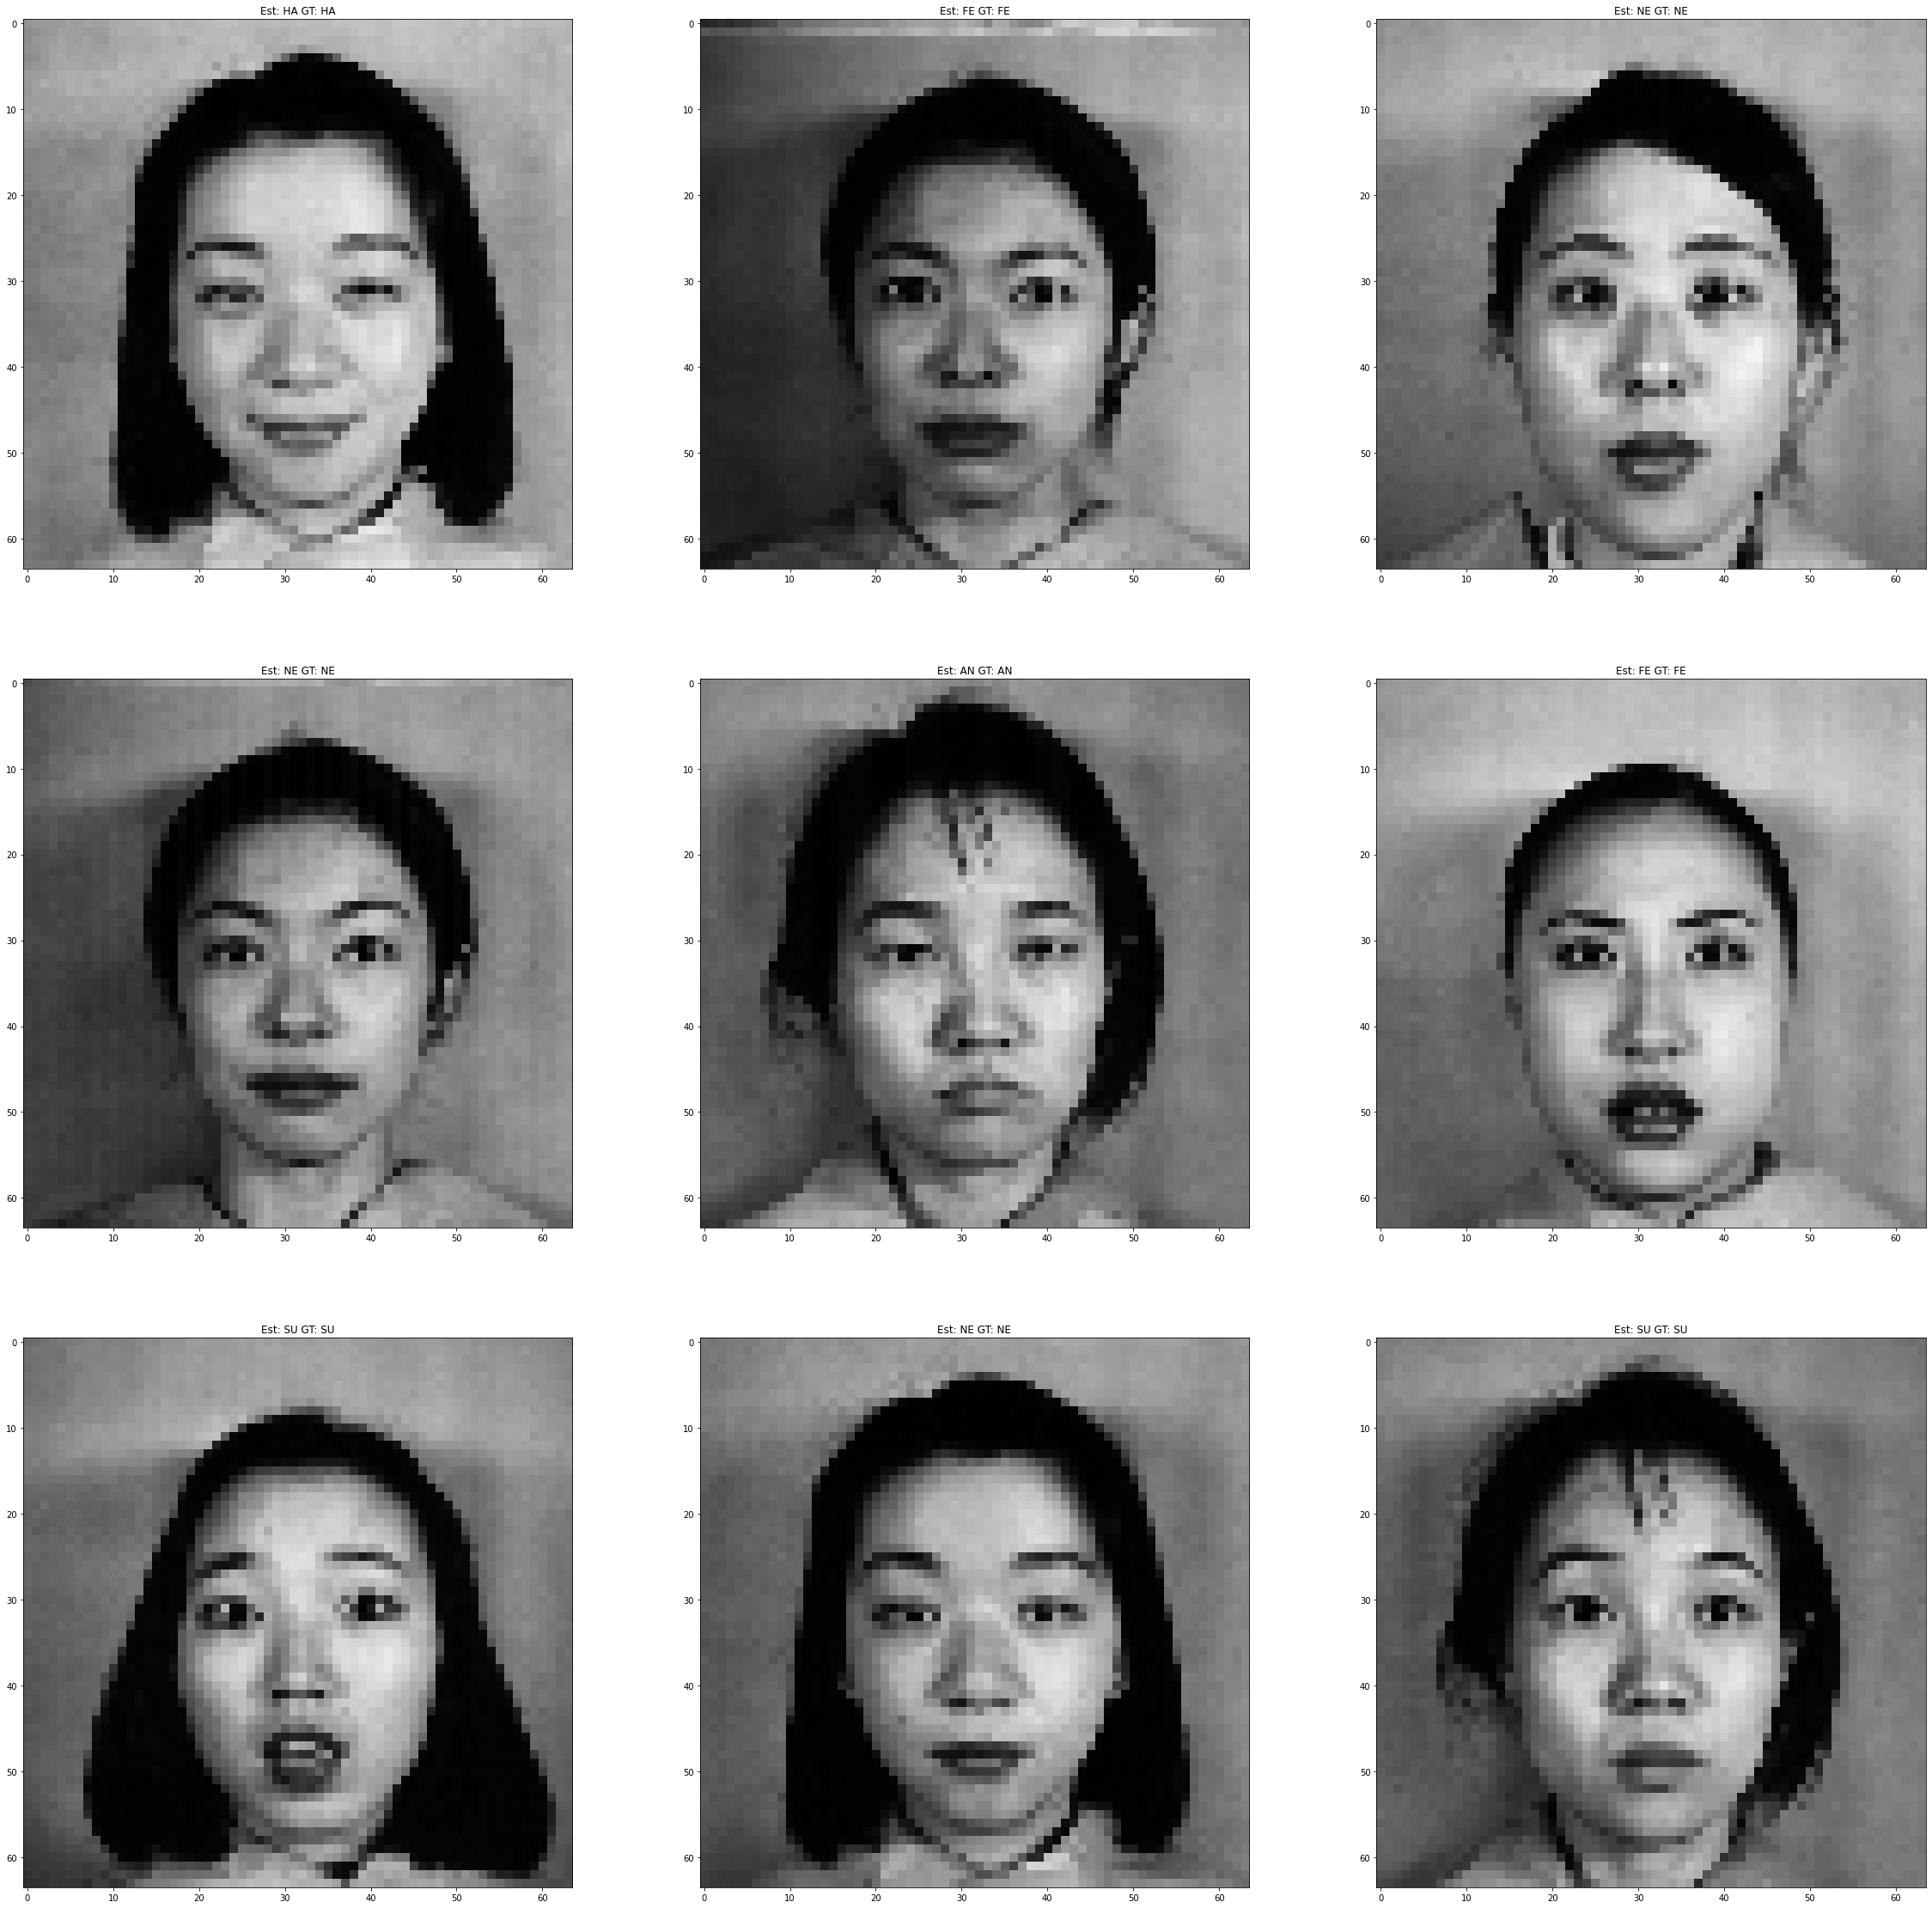

In [ ]:
# Create an NxN display of samples
N = 3
fig, axs = plt.subplots(N, N)

for i in range(3):
  for j in range(3):
    index = random.randint(0, len(test_images)-1) # pick a random index
    img = test_images[index].reshape(cols, rows, channels)
    correct_label = test_labels[index]
    predicted_label = predicted[index]

    axs[i, j].imshow(img)
    axs[i, j].set_title("Est: " + int_to_emotion[predicted_label] + " GT: " + int_to_emotion[correct_label])

# 4 FER with Multi-layer Perceptrons

A multi-layer perceptron (MLP) is a composite model where processing is distributed to small, simple, unit models called perceptrons or neurons. Each neuron, $i$, basically implements the following model:
$$
f_i(A) = g\left(\sum_j w_{ij} A_j + b_i \right),
$$
where $A$ is the vector of features from the previous layer (or the input layer); $w_{ij}$ is the weight (parameter) of the connection from perceptron $j$ to perceptron $i$; $b_i$ is the bias (intercept); and $g(\cdot)$ is an activation function, e.g. sigmoid, tanh, ReLU.

<img width="40%" src="https://scikit-learn.org/stable/_images/multilayerperceptron_network.png">

Given the raw outputs of the model, $o_i$, we will use cross-entropy loss to calculate the error of our predictions with respect to the targets, $y_i$:
$$
\mathcal{L}_{CE}(o, y) = - \sum_i y_i \log p_i + \alpha \frac{1}{2}\sum_{ij} w_{ij}^2,
$$
where $\alpha$ controls the regularization term; and the probability of prediction, $p_i$, is caculated using the softmax function:
$$
p_i = \frac{\exp(o_{y_i})}{\sum_j \exp(o_j)}.
$$
where $o_{y_i}$ is the raw output for the correct class.

The loss function $\mathcal{L}_{CE}$ is optimized generally using gradient descent:
$$
w_i \leftarrow w_i - \eta \frac{\partial \mathcal{L}_{CE}}{\partial w_i}.
$$

## 4.1 Define an MLP model


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 200), random_state=1, verbose=True)

print(mlp_classifier)
# alpha: L2 penalty (regularization term) parameter.
# beta_1, beta_2: parameters for first-order and second-order moments of Adam
# loss: cross-entropy loss.

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000, 200), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)
{'activation': 'relu', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (1000, 200), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': True, 'warm_start': False}


## 4.2 Train MLP

In [ ]:
# We learn the SVM model on the training data
mlp_classifier.fit(train_images, train_labels)

# Now predict on the test data
predicted = mlp_classifier.predict(test_images)
expected = test_labels

## 4.3 Results

### 4.3.1 Quantitative Results

In [ ]:
print("Classification report for classifier %s:\n%s\n"
      % (mlp_classifier, metrics.classification_report(expected, predicted)))

Classification report for classifier MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000, 200), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False):
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.80      0.67      0.73         6
           2       0.80      0.73      0.76        11
           3       1.00      0.67      0.80         9
           4       0.80      0.80      0.80         5
           5       0.67      1.00      0.80         2
           6       0.57      1.00      0.73         4

    accuracy                  

### 4.3.2 Confusion Matrix

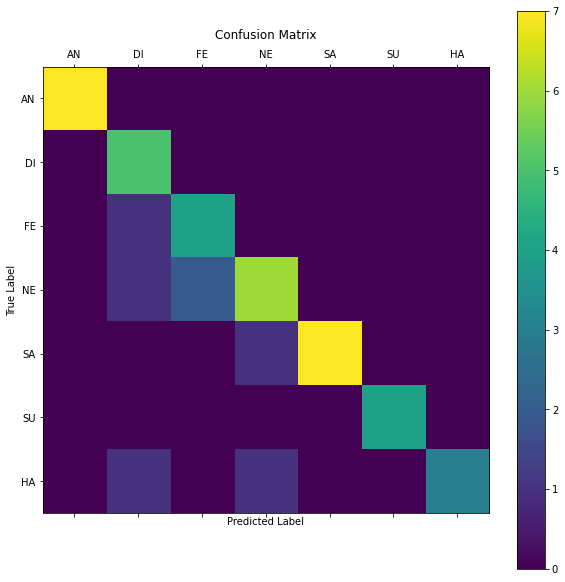

In [ ]:
cm = confusion_matrix(test_labels, predicted)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(ticks=range(0,7), labels=list(emotion_to_int.keys()))
plt.yticks(ticks=range(0,7), labels=list(emotion_to_int.keys()))
plt.show()

### 4.3.3 Qualitative Results

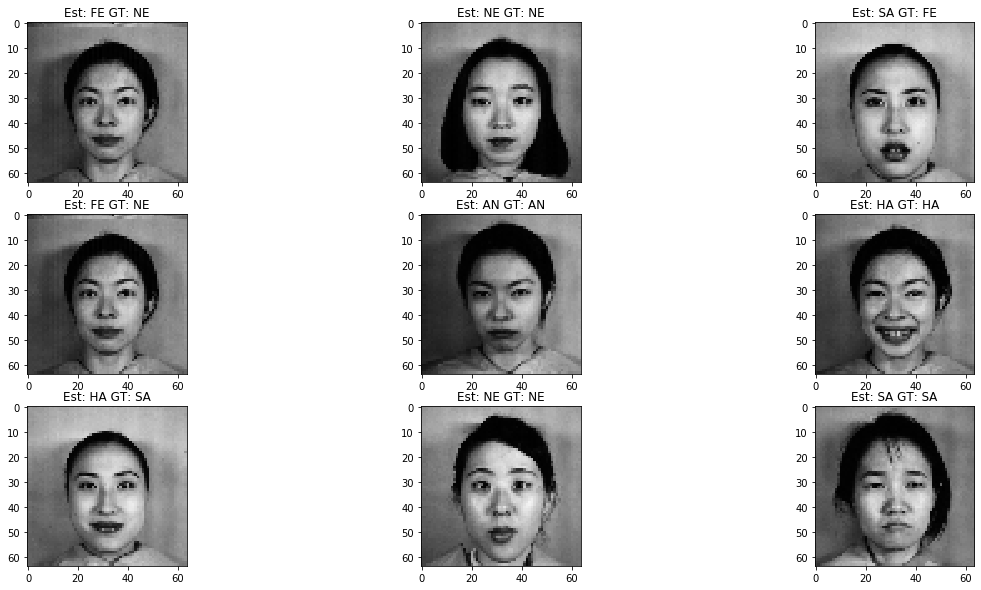

In [ ]:
# Create an NxN display of samples
N = 3
fig, axs = plt.subplots(N, N)

for i in range(3):
  for j in range(3):
    index = random.randint(0, len(test_images)-1) # pick a random index
    img = test_images[index].reshape(cols, rows, channels)
    correct_label = test_labels[index]
    predicted_label = predicted[index]

    axs[i, j].imshow(img)
    axs[i, j].set_title("Est: " + int_to_emotion[predicted_label] + " GT: " + int_to_emotion[correct_label])

## 4.4 Grid Search for Hyper-Parameters

Following the method performed for SVM, we can find the best hyper-parameters for MLP. However, this will take more time since the model is more complicated and we have more hyper-parameters (number of layers, number of neurons, activation functions, learning rate, optimization method, alpha, momentum constant, ...).

This is left as an exercise.